# Embeddingi w Uczeniu Maszynowym
Embedding to reprezentacja obiektów (np. słów, produktów, użytkowników) w przestrzeni wektorowej o niskim wymiarze. Umożliwia uchwycenie podobieństw semantycznych lub kontekstowych, których nie widać w prostych reprezentacjach.

Embeddingi istnieją tylko „na tokenach” i bez tokenizacji nie da się ich użyć.


## Token – co to jest?

**Token** to podstawowa jednostka tekstu, na której pracuje model NLP.
To „kawałek” zdania zamieniony na liczbę (indeks w słowniku).

### Rodzaje tokenów

* **słowo** – np. „lubię uczyć się” → `[lubię] [uczyć] [się]`
* **znak (litera)** – „kot” → `[k] [o] [t]`
* **subword (fragment wyrazu)** – „uczyłbym” → `[uczył] [by] [m]`
* **specjalne tokeny** – `<pad>` (padding), `<unk>` (nieznane słowo), `<cls>` (początek zdania)

### Token w praktyce

1. **Tokenizacja** – tekst dzielimy na tokeny.
   „lubię uczyć się pytorch” → `[1, 2, 3, 4]`
   (gdzie każdemu słowu przypisany jest numer w słowniku).
2. **Embedding** – każdy token (numer) zamieniany jest na wektor liczb.
   `[1, 2, 3, 4]` →

   ```
   [[0.01, -0.02, 0.03],   # token „lubię”
    [0.05,  0.01, -0.04],  # token „uczyć”
    [0.02,  0.07, -0.01],  # token „się”
    [0.09, -0.03, 0.02]]   # token „pytorch”
   ```

### Podsumowanie

* **Token = indeks w słowniku** (np. 2 → „uczyć”).
* **Embedding = wektor liczb przypisany do tokenu**, który reprezentuje jego znaczenie w przestrzeni wektorowej.



## Dlaczego embeddingi?
- **Problem z one-hot encodingiem**: 
  - wymiar wektora rośnie liniowo wraz z liczbą kategorii (np. dla 50 kategorii dostajemy wektory długości 50, w większości wypełnione zerami),
  - brak informacji o podobieństwie między kategoriami (wszystkie są tak samo odległe).
  - np. kategorie `1, 2, 3` → one-hot: `[1,0,0]`, `[0,1,0]`, `[0,0,1]`.
- **Embeddingi (gęste wektory)**:
  - reprezentują każdą kategorię jako wektor w przestrzeni o dużo niższym wymiarze (np. 50 kategorii → embeddingi 4-wymiarowe),
  - odległość i kierunek wektorów mogą uchwycić podobieństwo między kategoriami (np. `pies` i `kot` będą bliżej siebie niż `pies` i `samochód`).
- **Uczenie embeddingów**:
  - embeddingi są **parametrami modelu**,
  - są aktualizowane podczas trenowania (uczone end-to-end razem z resztą sieci),
  - dzięki temu model sam znajduje „najlepszą” reprezentację kategorii dla zadania.


## Jak embeddingi działają matematycznie
- Każdy obiekt otrzymuje numer (indeks).
- Indeks trafia do macierzy `E` o wymiarach `(liczba_kategorii, rozmiar_wektora)`.
- Wektor embeddingu to po prostu wiersz macierzy `E` wskazywany przez indeks.
- Podczas uczenia gradienty przepływają do odpowiednich wierszy, dzięki czemu wektory uczą się reprezentować relacje między obiektami.

### Przykład: od `one-hot` do embeddingu
Załóżmy, że mamy taki mały słownik:

```{"kot":0, "pies":1, "ryba":2}``` 

i rozmiar wektora równy 3. 

Macierz embeddingu `E` będzie miała kształt `(3, 3)`. 

Wektor *kot* to odpowiedni wiersz macierzy. 

Poniżej pokazujemy, jak można wykorzystać prostą tablicę NumPy do symulacji pobierania embeddingów.

In [94]:
import numpy as np

vocab = {"kot": 0, "pies": 1, "ryba": 2}
E = np.array([
    [0.2, 0.5, -0.1],  # wektor "kot"
    [0.3, 0.4, -0.2],  # wektor "pies"
    [-0.1, 0.7, 0.6],  # wektor "ryba"
])

word = "kot"
idx = vocab[word]
vector = E[idx]
vector

array([ 0.2,  0.5, -0.1])

Wynikowy wektor można użyć w dalszych obliczeniach (np. przekazać do warstw liniowych, LSTM czy Transformerów).

## Trenowanie embeddingów

Jedną z cech embeddingów jest to, że są uczone razem z modelem:

1. Inicjalizujemy macierz losowo (lub z pretreningu).
2. Przekazujemy indeksy kategorii przez warstwę embedding.
3. Strata (np. krzyżowa entropia) aktualizuje konkretne wiersze macierzy.
4. Po treningu mamy gęste reprezentacje uchwytujące współwystępowanie i podobieństwa.

Embeddingi można również wstępnie wytrenować (Word2Vec, GloVe) i później dostosować do konkretnego zadania.

### Embeddingi w TensorFlow

W TensorFlow mamy specjalną warstwę `tf.keras.layers.Embedding`, która przyjmuje parametry `input_dim` (rozmiar słownika) oraz `output_dim` (rozmiar wektora). 

Warto ustawić również `mask_zero=True`, jeśli `0` oznacza padding - czyli wypełnianie pustych miejsc. 

In [95]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

#### Słownik słów

`<pad>` = specjalny token paddingu, zawsze indeks `0`

Używa się go, aby "wypełnić" krótsze sekwencje do jednakowej długości.

Dzięki temu możemy ułożyć zdania w macierz (**batch**), gdzie wszystkie mają tyle samo elementów.

Padding to też jest token - tyle, że taki specjalny, który ma swój indeks, ale jest ignorowany w obliczeniach dzięki mask_zero / padding_idx”.

In [96]:
word_index = {"<pad>": 0, "lubię": 1, "uczyć": 2, "się": 3, "pytorch": 4, "tensorflow": 5}

#### zdania zakodowane indeksami (różne długości!)

In [97]:
sentences = [
    [1, 2],                # "lubię uczyć"
    [1, 5],                # "lubię tensorflow"
    [1, 2, 3, 4],          # "lubię uczyć się pytorch"
    [1, 2, 3, 5, 4],        # "lubię uczyć się tensorflow pytorch"
    [1, 4, 1, 5, 1, 2, 3]  # "lubię pytorch lubię tensorflow lubie uczyć się
]



### Co to jest *batch*?

Mamy 5 zdań - najdłuższe ma 7 wyrazów. Nasza próbka będzie mieć więc wymiar 5 x 7. Jak zbudujemy z tego macierz wypełnioną paddingami to to będzie batch - próbka

* **Batch** = paczka/próbka zbiorcza danych, którą podajemy **naraz** do modelu w jednej iteracji.
* Zamiast uczyć model na **pojedynczym zdaniu**, bierzemy kilka naraz, żeby:

  1. **przyspieszyć uczenie** (wykorzystujemy równoległość na GPU),
  2. **ustabilizować gradienty** (średnia z kilku próbek jest mniej „szarpana” niż z jednej).


In [98]:
# pad_sequences?

In [99]:

# --- padding do równej długości ---
# domyślnie pad_sequences uzupełnia zerami (czyli <pad>)
sequences = pad_sequences(sentences, padding="post")

print("Sekwencje po paddingu:\n", sequences)


Sekwencje po paddingu:
 [[1 2 0 0 0 0 0]
 [1 5 0 0 0 0 0]
 [1 2 3 4 0 0 0]
 [1 2 3 5 4 0 0]
 [1 4 1 5 1 2 3]]


In [100]:

# --- Warstwa embedding ---
embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(word_index),  # rozmiar słownika = 6 (liczymy też <pad>)
    output_dim=4,               # każdy token będzie reprezentowany 4 liczbowymi współrzędnymi
    mask_zero=True,             # bardzo ważne: ignoruj indeks 0 (czyli padding)
)

# --- Zastosowanie warstwy embedding ---
embedded = embedding_layer(sequences)
embedded.shape

TensorShape([5, 7, 4])

Zwrócony tensor ma kształt `(batch, sequence_length, output_dim)`.

Warstwę embedding można dalej połączyć z modelami sekwencyjnymi (LSTM, GRU) lub konwolucyjnymi.

### Mini model z embeddingiem TensorFlow

Poniżej prosty model klasyfikacji sentymentu złożony z embeddingu, warstwy global average pooling i gęstej warstwy wyjściowej.

Warstwa global average pooling uśrednia wektory embeddingów wszystkich tokenów w zdaniu, tworząc jeden reprezentacyjny wektor zdania niezależny od jego długości.

In [101]:
model_tf = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(word_index), output_dim=4, mask_zero=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

model_tf.compile(optimizer="adam", loss="binary_crossentropy")
model_tf.build(input_shape=(None, 5))
model_tf.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 5, 4)           │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 4)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29 (116.00 B)

 Trainable params: 29 (116.00 B)

 Non-trainable params: 0 (0.00 B)

In [102]:
import tensorflow as tf
import numpy as np

# Załóżmy słownik o rozmiarze 6 (tokeny 0–5), embedding 4D
embedding_layer = tf.keras.layers.Embedding(input_dim=6, output_dim=4, mask_zero=True)

# Przykładowe zdania zakodowane jako indeksy tokenów
# 0 = padding
sentences = np.array([
    [1, 2, 3, 0, 0],   # zdanie 1: trzy tokeny + padding
    [4, 5, 1, 0, 0],   # zdanie 2: dwa tokeny + padding
])

print("Kształt wejścia:", sentences.shape)

# Embedding
embedded = embedding_layer(sentences)
print("Kształt po embeddingu:", embedded.shape)
embedded

Kształt wejścia: (2, 5)
Kształt po embeddingu: (2, 5, 4)


<tf.Tensor: shape=(2, 5, 4), dtype=float32, numpy=
array([[[-0.04859709,  0.04813931, -0.02673558,  0.03258622],
        [-0.03453139,  0.04224342,  0.01542932,  0.00607534],
        [-0.02308285,  0.03955093, -0.00429424, -0.04624949],
        [-0.03083962, -0.03724318,  0.03123887, -0.02536358],
        [-0.03083962, -0.03724318,  0.03123887, -0.02536358]],

       [[-0.03374977,  0.04049555,  0.0312377 ,  0.00256505],
        [-0.03451729,  0.01253356,  0.02043447,  0.0099626 ],
        [-0.04859709,  0.04813931, -0.02673558,  0.03258622],
        [-0.03083962, -0.03724318,  0.03123887, -0.02536358],
        [-0.03083962, -0.03724318,  0.03123887, -0.02536358]]],
      dtype=float32)>

A więc 1 zdanie to taka macierz - coś takieggo (bedzie sie zmieniac przy uruchomieniach)

        [[ 0.01423473, -0.00483084, -0.02746737, -0.02501923],  # 1
        [ 0.02149788, -0.04756809, -0.04644064, -0.00472618],   # 2   
        [ 0.00689582,  0.03334036, -0.00995095, -0.02848799],   # 3 
        [-0.02906418, -0.01756475,  0.00183201,  0.03547058],   # 0
        [-0.02906418, -0.01756475,  0.00183201,  0.03547058]]   # 0

I pooling sumuje to kolumnami i liczy średnią - ale pomija to co jest naszym paddingiem

To 1, 2, 3  nazywamy tokenami - czyli najmniejszymi porcjami tekstu, który rozumie nasz model


In [103]:
# Global Average Pooling
pooled = tf.keras.layers.GlobalAveragePooling1D()(embedded)
print("Kształt po pooling:", pooled.shape)
print("Wektor reprezentujący każde zdanie:\n", pooled.numpy())

Kształt po pooling: (2, 4)
Wektor reprezentujący każde zdanie:
 [[-0.03540378  0.04331122 -0.00520017 -0.00252931]
 [-0.03895472  0.0337228   0.0083122   0.01503795]]


### Embeddingi w PyTorch
W PyTorch embeddingi tworzymy przez `torch.nn.Embedding(num_embeddings, embedding_dim)`. Przykład poniżej pokazuje pobieranie wektorów oraz prosty model klasyfikacyjny.

In [104]:
import torch
import torch.nn as nn

from torch.nn.utils.rnn import pad_sequence

# --- przykładowe zdania o różnej długości ---
sentences = [
    torch.tensor([1, 2]),          # "lubię uczyć"
    torch.tensor([1, 2, 3, 4]),    # "lubię uczyć się pytorch"
    torch.tensor([1, 2, 3, 5, 4])  # "lubię uczyć się tensorflow pytorch"
]

# --- padding ---
# domyślnie padding jest z lewej (do najdłuższej sekwencji)
seqences = pad_sequence(sentences, batch_first=True, padding_value=0)

print(seqences)
print("Kształt:", seqences.shape)


tensor([[1, 2, 0, 0, 0],
        [1, 2, 3, 4, 0],
        [1, 2, 3, 5, 4]])
Kształt: torch.Size([3, 5])


In [105]:
embedding = nn.Embedding(num_embeddings=len(word_index), embedding_dim=4, padding_idx=0)
embedded_torch = embedding(seqences)
embedded_torch.shape

torch.Size([3, 5, 4])

Tu nasz batch_size to 3, najdłuższe zdanie ma 5 wyrazów a embedding ma wymiar 4

#### Mini model z embeddingiem w PyTorch
Poniższy moduł wykorzystuje warstwę embedding, uśrednia wektory wzdłuż sekwencji i przekazuje wynik do warstwy liniowej. To minimalny szkic klasyfikatora tekstu opartego na PyTorch.

In [106]:
class SimpleTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(embed_dim, 1)

    def forward(self, x):
        embedded = self.embedding(x)  # (batch, seq, embed_dim)
        # zamieniamy na (batch, embed_dim, seq), aby użyć 1D pooling
        pooled = self.pool(embedded.transpose(1, 2)).squeeze(-1)
        logits = self.classifier(pooled)
        return torch.sigmoid(logits)

model_torch = SimpleTextClassifier(vocab_size=len(word_index), embed_dim=4)
model_torch

SimpleTextClassifier(
  (embedding): Embedding(6, 4, padding_idx=0)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (classifier): Linear(in_features=4, out_features=1, bias=True)
)

In [107]:
with torch.no_grad():
    pred = model_torch(seqences)

pred

tensor([[0.5364],
        [0.5611],
        [0.5526]])

## 6. Dobre praktyki i wskazówki
- Dobierz `embedding_dim` do wielkości słownika (zazwyczaj 16–300 dla prostych zadań NLP, więcej dla rekomendacji).
- Używaj `padding_idx` (PyTorch) lub `mask_zero` (TensorFlow), jeśli w sekwencjach występują wartości wypełniające.
- Możesz zacząć od losowej inicjalizacji i pozwolić modelowi uczyć się embeddingów lub wykorzystać embeddingi pretrenowane (np. FastText) i dostosować je (`fine-tuning`).
- Analizuj embeddingi po treningu: wizualizuj PCA/TSNE, porównuj najbliższe wektory, by zweryfikować, czy model nauczył się semantyki.

## 7. Zastosowania embeddingów
- Natural Language Processing (word embeddings, sentence embeddings, wektory dokumentów).
- Systemy rekomendacji (embeddingi użytkowników i produktów).
- Modele grafowe (Graph Embedding, Node2Vec).
- Kodowanie zmiennych kategorycznych w modelach tablicowych (np. tabular deep learning).

Embeddingi stanowią fundament nowoczesnych modeli, ponieważ pozwalają zamienić surowe kategorie na przestrzenie, w których łatwiej znaleźć wzorce.

## Przykład: embeddingi w prostym modelu

Symulujemy prosty zbiór danych klientów:

* **`region`** – kategoria (10 regionów, zakodowane jako liczby 0–9),
* **`wiek`** – zmienna ciągła,
* **`dochód`** – zmienna ciągła,
* **`abonament`** – target (0/1, czy klient ma abonament).

W typowym ML:

* cechy ciągłe możemy podać „tak jak są” (po normalizacji/standaryzacji),
* ale **cechy kategoryczne** (jak `region`) nie mają sensownego porządku → tu właśnie używamy **embeddingów**.

In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ---------------------
# 1. Dane przykładowe
# ---------------------
np.random.seed(42)

n_samples = 500
n_regions = 10  # kategorie regionów

raw_data = pd.DataFrame({
    # to są od razu indeksy kategorii wiec nie zamieniam juz tego na dane kategoryczne
    # gdyby tu były jakies labelki - typu "dolnosląski", "polnocno-zachodni" itd to zamieniałbym
    "region": np.random.randint(0, n_regions, size=n_samples),  
    "wiek": np.random.randint(18, 70, size=n_samples),
    "dochód": np.random.randint(2000, 12000, size=n_samples),
    "abonament": np.random.randint(0, 2, size=n_samples)  # target: 0/1
})

categorical_cols = ["region"]
continuous_cols = ["wiek", "dochód"]
target_col = "abonament"

X_cat = torch.tensor(raw_data[categorical_cols].values, dtype=torch.long)
X_cont = torch.tensor(raw_data[continuous_cols].values, dtype=torch.float32)
y = torch.tensor(raw_data[target_col].values, dtype=torch.float32).view(-1, 1)


---

### 2. Model

* Dla cechy kategorycznej `region` uczymy **embedding** o wymiarze 6 (czyli każdemu regionowi odpowiada wektor długości 6).
* Dla cech ciągłych (`wiek`, `dochód`) stosujemy prostą warstwę liniową, aby dopasować skalę.
* Oba wektory (embedding + cechy ciągłe) są łączone i wysyłane do sieci neuronowej, która przewiduje `abonament`.

In [109]:

# ---------------------
# 2. Model z embeddingami
# ---------------------
class CustomerModel(nn.Module):
    def __init__(self, n_regions, emb_dim, n_cont):
        super().__init__()
        # embedding dla zmiennej kategorycznej "region" - wartość będzie podana przy inicjalizacji
        self.emb = nn.Embedding(n_regions, emb_dim)
        # warstwa dla cech ciągłych
        self.fc_cont = nn.Linear(n_cont, 4)
        # klasyfikator końcowy
        self.fc = nn.Sequential(
            nn.Linear(emb_dim + 4, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x_cat, x_cont):
        x_emb = self.emb(x_cat).squeeze(1)        # embedding regionu
        x_cont = self.fc_cont(x_cont)             # przekształcone dane ciągłe
        x = torch.cat([x_emb, x_cont], dim=1)     # połączenie
        return self.fc(x)

model = CustomerModel(n_regions=n_regions, emb_dim=6, n_cont=len(continuous_cols))


---

### 3. Trening

Model uczy się end-to-end:

* embeddingi regionów są **parametrami sieci**,
* w trakcie treningu są aktualizowane, aby jak najlepiej pomagały w przewidywaniu abonamentu.

W praktyce oznacza to: **regiony, które w podobny sposób wpływają na prawdopodobieństwo posiadania abonamentu, będą miały embeddingi bliżej siebie w przestrzeni wektorowej**.

---

### 4. Analiza embeddingów

Po treningu wyciągamy macierz embeddingów:

In [110]:
embeddings = model.emb.weight.detach().numpy()

embeddings[0]

array([-0.6737331 , -0.60998917, -0.22300157,  1.916311  , -0.25630867,
        0.7061841 ], dtype=float32)

* kształt = `10 x 6` (10 regionów, embedding_dim=6),
* każda linia = wektor opisujący dany region. Ten wektor ma 6 współrzędnych.

Aby je zobaczyć:

* redukujemy wymiar do 2D przy pomocy PCA,

### PCA — Principal Component Analysis (Analiza Głównych Składowych)

Metoda redukcji wymiaru, która przekształca dane do nowej przestrzeni współrzędnych,
tak aby **pierwsze składowe** przechwytywały jak najwięcej wariancji w danych.

In [111]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

embeddings_2d[0]

array([-1.6035028, -0.3859304], dtype=float32)

* rysujemy punkty odpowiadające regionom.

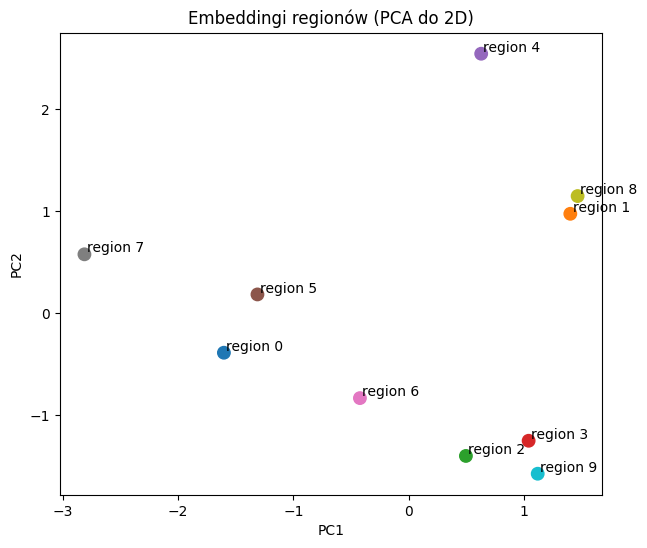

In [112]:
plt.figure(figsize=(7, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=range(n_regions), cmap="tab10", s=80)

for i in range(n_regions):
    plt.annotate(f"region {i}", (embeddings_2d[i, 0]+0.02, embeddings_2d[i, 1]+0.02))

plt.title("Embeddingi regionów (PCA do 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Wykres pokazuje, że **niektóre regiony grupują się bliżej siebie** — czyli model „uznał”, że są podobne z punktu widzenia abonamentu.

---

### 5. Wnioski i korzyści z embeddingów

1. **Redukcja wymiarowości**

   * Zamiast one-hot (10 kategorii → wektor długości 10), używamy embeddingów (np. wymiar 6).
   * Przy większych słownikach (np. 1000 kategorii) oszczędność jest ogromna.

2. **Uchwycenie podobieństw**

   * W one-hot wszystkie kategorie są „równie odległe”.
   * Embeddingi pozwalają modelowi samodzielnie nauczyć się, które kategorie są podobne.
   * Np. regiony o podobnej strukturze klientów będą mieć wektory bliżej siebie.

3. **Uczą się razem z modelem**

   * Nie musimy ręcznie kodować relacji między kategoriami.
   * Model sam znajdzie najlepszą reprezentację dla danego zadania.

4. **Łatwość analizy**

   * Po treningu embeddingi można interpretować:

     * grupować kategorie,
     * wizualizować (PCA/t-SNE/UMAP),
     * szukać najbliższych sąsiadów (np. „które regiony są najbardziej podobne?”).

---

✅ **Podsumowanie**:
W tym przykładzie embedding pozwala traktować **region** nie jako arbitralny numer, lecz jako **punkt w przestrzeni wektorowej**, gdzie bliskość oznacza podobieństwo w kontekście abonamentu. Dzięki temu model uczy się szybciej, ma mniej parametrów i potrafi generalizować lepiej niż przy gołym one-hot encodingu.

